# Ejercicio 5 - Regularización

La regularización busca resolver problemas mal condicionados a partir del conocimiento de problemas bien condicionados, buscando un balance entre amplificación del ruido y calidad de la reconstrucción.
Los métodos más comunes de regularización se dividen en directos, iterativos, recursivos y estocásticos.

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import cv2 as cv

In [6]:
import scipy.io

### Carga de la imagen

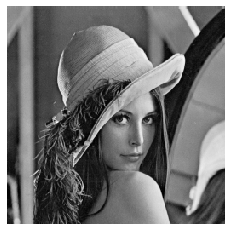

In [22]:
img = scipy.io.loadmat('../resources/lena.mat')['lenna'] / 255

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Distorsion de la imagen

In [23]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift 

In [41]:
def get_ideal_lowpass(order, size):
    """ Creates an ideal lowpass 2D filter with the size of the image.
        @param order Order of the kernel or mask
        @param size Size of the image (width, height)
        @return Image sized kernel
    """
    # Extract the width and height from the size parameters
    N, M = size
    
    # Create the kernel
    kernel = np.zeros((N, M))
    n = np.int(order/2)
    m = np.int(M / 2)
    kernel[m-n:m+n+1,m-n:m+n+1] = np.ones((order, order)) / (order**2)
    
    # Return the kernel
    return kernel

In [42]:
def apply_filter(kernel, image):
    """ Apply a 2D filtering to an image in the frequency domain using a kernel.
        with the same size of the image.
        @param kernel Filter kernel or mask
        @param image Image to filter
        @return Resulting image
    """
    image_spectrum = np.fft.fftshift(np.fft.fft2(image))
    kernel_spectrum = np.fft.fftshift(np.fft.fft2(kernel))
    return np.abs(np.fft.fftshift(np.fft.ifft2(image_spectrum * kernel_spectrum)))

In [61]:
def blurr_fft_gonza(img):
    
    # Calculate an ideal low pass filter
    kernel = get_ideal_lowpass(7, img.shape)

    # Apply a blurr effect to the image
    img_blurred = apply_filter(kernel, img)
    
    return img_blurred, fft2(kernel)

In [27]:
def blurr_fft(img):
   # Build and apply a Gaussian filter.
    n_img = img.shape[0]
    sigma = 50
    c = n_img/2
    x = np.linspace(0, n_img, n_img)
    y = np.linspace(0, n_img, n_img)
    X, Y = np.meshgrid(x, y)
    H = np.exp(-(((X-c)/sigma)**2 + ((Y-c)/sigma)**2))

    I = fftshift(fft2(img))

    Y = H * I

    blurred_img = ifft2(ifftshift(Y)).real
 
    return blurred_img, H

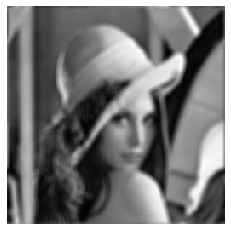

In [62]:
img_distorted_fft, H = blurr_fft_gonza(img)

plt.figure()
plt.imshow(img_distorted_fft, cmap='gray')
plt.axis('off')
plt.show()

## Agregado de ruido

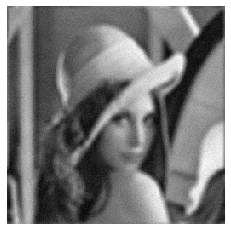

In [64]:
SNRdB = 20
std_dev = np.std(img_distorted_fft)
sigma_noise = np.sqrt( std_dev **2 * 10 ** (-SNRdB / 10))
noise =  np.random.normal(loc=0, scale=sigma_noise, size=img.shape)
g = img_distorted_fft + noise
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

## Restauración por Wien

In [75]:
def restore_wien(original_img, degraded_img, noise, H):
    deg_img_fft = fft2(degraded_img)
    
    Snn = np.square(np.abs(fft2(noise)))
    Sff = np.square(np.abs(fft2(original_img)))

    restored_img_fft = fftshift(deg_img_fft * np.conj(H) / (H * np.conj(H) + Snn / Sff))
    
    restored_img = np.abs(fftshift(ifft2(ifftshift(restored_img_fft))))
    return restored_img

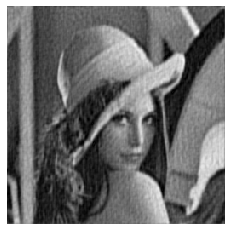

In [76]:
img_restored_wien = restore_wien(img, g, noise, H)
plt.imshow(img_restored_wien, cmap='gray')
plt.axis('off')
plt.show()

In [90]:
def restore(H, g, noise, img, k):
    """
    @param H   Kernel in the frequency domain which degraded the image
    @param g   Degraded (filtered and noisy) image
    @param noise Noise
    @param img  Original image
    """
    g_fft = fft2(g)
    
    Sxx_Snn_dB = 3
    Snn_Sxx = 10**(-Sxx_Snn_dB/10)
    
    restored_img = np.abs(fftshift(ifft2((g_fft * np.conj(H)) / (H * np.conj(H) + Snn_Sxx))))
    
    GH = np.max(np.abs((H * np.conj(H)) / (H * np.conj(H) + Snn_Sxx)))
    ZK = (k+1) * (GH) ** k
    
    Snn_Sxx_dB = 10*np.log10(Snn_Sxx)

    Ck = np.max(np.abs( H * np.conj(H))) * (np.exp(1/(1+k))-1)
    Ck_dB = 10 * np.log10(Ck)
    
    return restored_img, GH, ZK


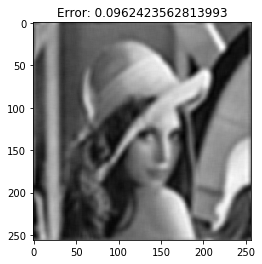

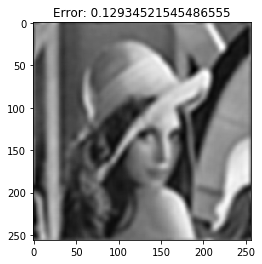

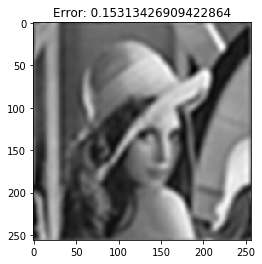

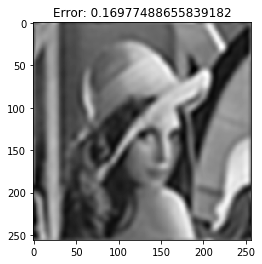

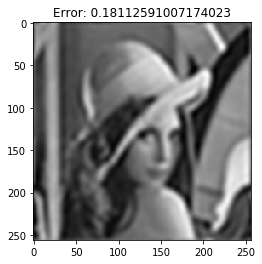

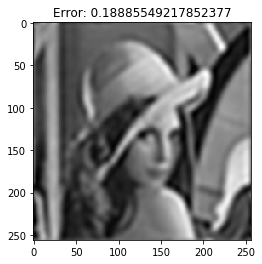

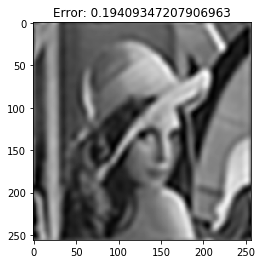

In [91]:
restored_img = g
for k in range(7):
    restored_img, GH, ZK = restore(H, restored_img, noise, img, k)

    err = np.std(restored_img - img)
    plt.figure()
    plt.imshow(restored_img, cmap='gray')
    plt.title(f'Error: {err}')
plt.show()